<a href="https://colab.research.google.com/github/pascale25/YbtO9JT8miFZIZdm/blob/master/Potential__Talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

##  Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:

- id : unique identifier for candidate (numeric)

- job_title : job title for candidate (text)

- location : geographical location for candidate (text)

- connections: number of connections candidate has, 500+ means over 500 (text)

- Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”


Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

Bonus(es):

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 0. Import libraries

In [4]:
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns
import re
import os
import pickle 
#import mglearn
import time

from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:

## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get the data 

In [7]:
os.listdir("gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J")

['glove.6B.50d.txt',
 'Copy of potential-talents.gsheet',
 'potential-talents.csv',
 'glove.6B.50d.txt.zip',
 'Potential _Talents.ipynb']

In [8]:
data = "gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/potential-talents.csv"

In [9]:
# read data 
df = pd.read_csv(data)
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [10]:
# check the shape, Null value
print(df.shape)
print('................................................')
print(df.isna().sum())
print('................................................')
print(df.info())

(104, 5)
................................................
id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64
................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB
None


In [11]:
df.duplicated().sum()

0

In [12]:
df.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [13]:
df.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

In [14]:
len(df.location.unique())

41

In [15]:
df.connection.unique()

array(['85', '500+ ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

In [16]:
len(df.connection.unique())

33

In [17]:
# replace 500+ part 501
df[df['connection'] == '500+ ']

,id,job_title,location,connection,fit
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN
12,13,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,NaN
15,16,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
17,18,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
19,20,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN


In [18]:
df.replace('500+ ','501', inplace=True)

In [19]:
df['connection'] = pd.to_numeric(df['connection'])

# EDA on connection variable

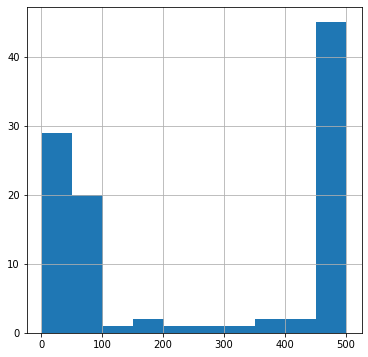

In [20]:
# 
df['connection'].hist(figsize=(6, 6) )

# EDA on Jobs Title variable 

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
string.punctuation
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopword = stopwords.words('english')
#text = [wn.lemmatize(word) for word in tokens if word not in stopword] # stemming
def clean_text(text):
  """ lower case, remove special caracter and  split into token"""
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+', text)
  # remove words that contain numbers
  text = [word for word in text if not any(c.isdigit() for c in word)]
  return tokens

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
df.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [24]:
df['job_clean'] = df['job_title'].apply(lambda row: clean_text(row))
df['location_clean'] = df['location'].apply(lambda row: clean_text(row))

In [25]:
df.head(5)

,id,job_title,location,connection,fit,job_clean,location_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,"[2019, ct, bauer, college, of, business, gradu...","[houston, texas]"
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN,"[native, english, teacher, at, epik, english, ...",[kanada]
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,"[aspiring, human, resources, professional]","[raleighdurham, north, carolina, area]"
3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN,"[people, development, coordinator, at, ryan]","[denton, texas]"
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN,"[advisory, board, member, at, celal, bayar, un...","[i, zmir, türkiye]"


In [26]:
df.job_title[0]

'2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'

In [27]:
#nltk.download('omw-1.4')

In [28]:
wn = nltk.WordNetLemmatizer()
def clean_text_lem(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [t for t in tokens if t.isalpha()] # remove numeric 
    tokens = [word for word in tokens if not any(c.isdigit() for c in word)]                      
    text = [wn.lemmatize(word) for word in tokens if word not in stopword] # stemming and remove stopword 
    # remove empty tokens and tokens of 1 letter 
    text = [t for t in text if len(t) > 3]
    # join all
    #text = " ".join(text)
    return text

In [29]:
job = df.job_title[0]
job

'2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'

In [30]:
clean_text(job)

['2019',
 'ct',
 'bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

In [31]:
clean_text_lem(job)

['bauer',
 'college',
 'business',
 'graduate',
 'magna',
 'laude',
 'aspiring',
 'human',
 'resource',
 'professional']

In [32]:
df['job_clean_lem'] = df['job_title'].apply(lambda row: clean_text_lem(row))
df['location_clean_lem'] = df['location'].apply(lambda row: clean_text_lem(row))

In [33]:
df.head(2)

,id,job_title,location,connection,fit,job_clean,location_clean,job_clean_lem,location_clean_lem
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,"[2019, ct, bauer, college, of, business, gradu...","[houston, texas]","[bauer, college, business, graduate, magna, la...","[houston, texas]"
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN,"[native, english, teacher, at, epik, english, ...",[kanada],"[native, english, teacher, epik, english, prog...",[kanada]


In [34]:
df['job_clean_lem'].head(5)

0    [bauer, college, business, graduate, magna, la...
1    [native, english, teacher, epik, english, prog...
2            [aspiring, human, resource, professional]
3             [people, development, coordinator, ryan]
4    [advisory, board, member, celal, bayar, univer...
Name: job_clean_lem, dtype: object

In [35]:
# Import Counter
#from collections import Counter 
# Create a Counter with the lowercase tokens (it is a bag of word of clean job lem)
BOW_jobs = df['job_clean_lem'].apply(lambda row: Counter(row)) 
BOW_jobs.head(5)

0    {'bauer': 1, 'college': 1, 'business': 1, 'gra...
1    {'native': 1, 'english': 2, 'teacher': 1, 'epi...
2    {'aspiring': 1, 'human': 1, 'resource': 1, 'pr...
3    {'people': 1, 'development': 1, 'coordinator':...
4    {'advisory': 1, 'board': 1, 'member': 1, 'cela...
Name: job_clean_lem, dtype: object

In [36]:
count_jobs=[]

for row in df['job_clean_lem']:
    for word in row:
        count_jobs.append(word)
        
jobs_counts=Counter(count_jobs)
print('number of unique word in the genre is', len (jobs_counts)) # get all the word use in Genres and count the number 

# Print the 10 most common tokens
print(jobs_counts.most_common(10))

number of unique word in the genre is 160
[('human', 63), ('resource', 63), ('aspiring', 35), ('professional', 21), ('student', 16), ('seeking', 15), ('college', 14), ('generalist', 14), ('university', 12), ('specialist', 12)]


In [37]:
df_job = pd.DataFrame(dict(jobs_counts), index = [0]).T.sort_values(by = 0)
df_job = df_job.rename(columns = {0: 'count_jobs_title'})
df_job.tail(10)

,count_jobs_title
university,12
specialist,12
generalist,14
college,14
seeking,15
student,16
professional,21
aspiring,35
resource,63
human,63


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, '20 Top job title words')

Text(0.5, 0, 'count')

Text(0, 0.5, 'job title')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

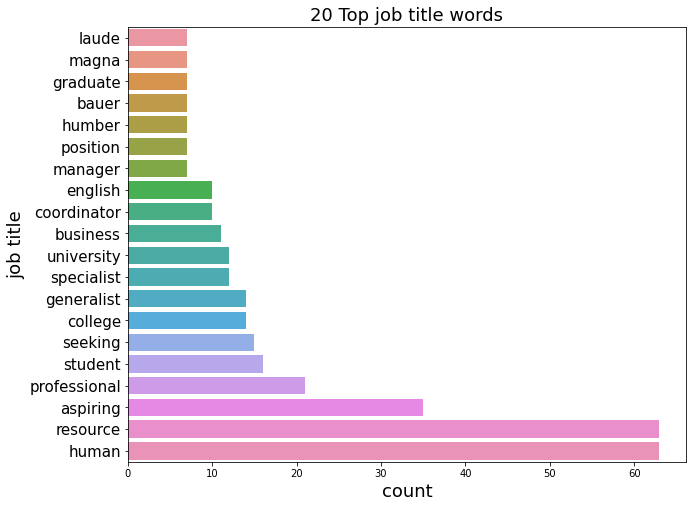

In [38]:
# dict(genres_counts) convert to dictionary
dfg = df_job.tail(20)
plt.figure(figsize = (10,8))
sns.barplot(data = dfg, y= dfg.index, x='count_jobs_title')
plt.title('20 Top job title words', fontsize =18)
plt.xlabel('count', fontsize =18)
plt.ylabel('job title', fontsize =18)
plt.yticks(fontsize=15)
plt.show()

In [39]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [40]:
count_jobs[:9]

['bauer',
 'college',
 'business',
 'graduate',
 'magna',
 'laude',
 'aspiring',
 'human',
 'resource']

In [41]:
all_words_joined = ' '.join(count_jobs)
all_words_joined

'bauer college business graduate magna laude aspiring human resource professional native english teacher epik english program korea aspiring human resource professional people development coordinator ryan advisory board member celal bayar university aspiring human resource specialist student humber college aspiring human resource generalist senior specialist student humber college aspiring human resource generalist seeking human resource hris generalist position student chapman university chro marketing communication officer engie houston woodland energy gphr sphr human resource coordinator intercontinental buckhead atlanta bauer college business graduate magna laude aspiring human resource professional bauer college business graduate magna laude aspiring human resource professional native english teacher epik english program korea aspiring human resource professional people development coordinator ryan bauer college business graduate magna laude aspiring human resource professional na

In [42]:
def generate_show_wordcloud(tokens):
    plt.figure(figsize = (15, 15), facecolor = None) 
    wordcloud = WordCloud(width = 1600, height = 1000, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(tokens)
    #plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('jobs title analysis', fontsize = 20)
    plt.show()

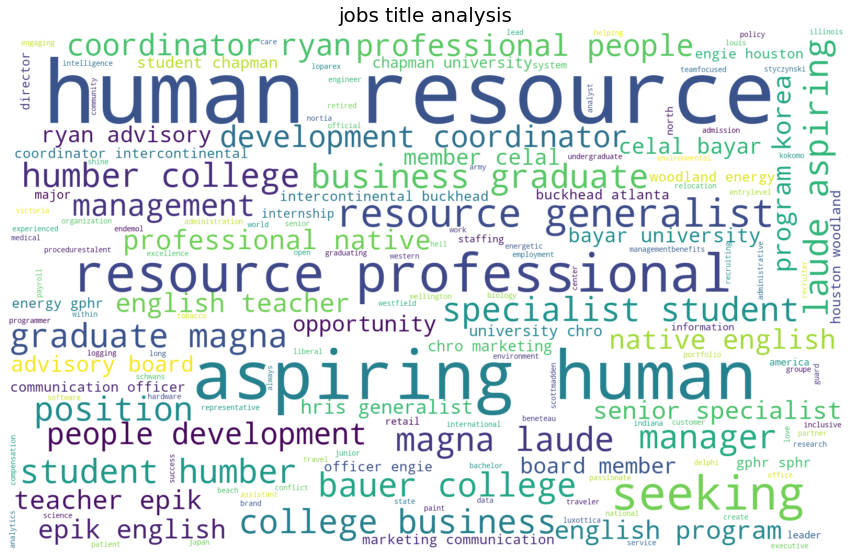

In [43]:
# plot the WordCloud image
generate_show_wordcloud(all_words_joined)

# EDA on location variable

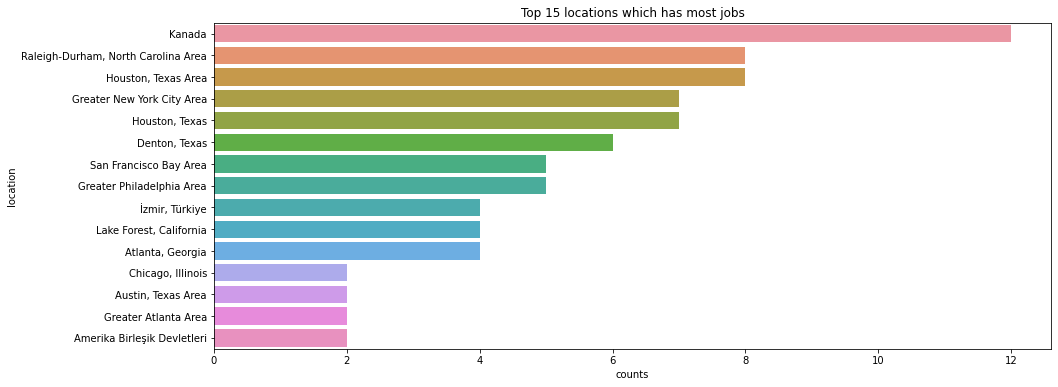

In [44]:
# Country with most numbers of title
plt.figure(figsize=(15,6))
top_locations = df['location'].value_counts().rename_axis('location').reset_index(name = 'counts')[:15]

sns.barplot(data = top_locations, x='counts', y ='location')
plt.title('Top 15 locations which has most jobs');

In [45]:
BOW_location = df['location_clean_lem'].apply(lambda row: Counter(row)) 
BOW_location.head(5)

0                           {'houston': 1, 'texas': 1}
1                                        {'kanada': 1}
2    {'raleighdurham': 1, 'north': 1, 'carolina': 1...
3                            {'denton': 1, 'texas': 1}
4                            {'zmir': 1, 'türkiye': 1}
Name: location_clean_lem, dtype: object

In [46]:
count_location=[]

for row in df['location_clean_lem']:
    for word in row:
        count_location.append(word)

location_counts=Counter(count_location)
print('number of unique word in the genre is', len(location_counts)) # get all the word use in Genres and count the number 

# Print the 10 most common tokens
print(location_counts.most_common(10))

number of unique word in the genre is 64
[('area', 49), ('texas', 24), ('greater', 18), ('houston', 15), ('kanada', 12), ('california', 10), ('carolina', 9), ('york', 9), ('raleighdurham', 8), ('north', 8)]


In [47]:
dict_location = dict(location_counts)
dict_location.pop('area')

49

In [48]:
df_location = pd.DataFrame(dict_location, index = [0]).T.sort_values(by = 0)
df_location = df_location.rename(columns = {0: 'count_location'})
df_location.tail(10)

,count_location
city,7
north,8
raleighdurham,8
york,9
carolina,9
california,10
kanada,12
houston,15
greater,18
texas,24


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, '20 Top job title words')

Text(0.5, 0, 'count')

Text(0, 0.5, 'job title')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

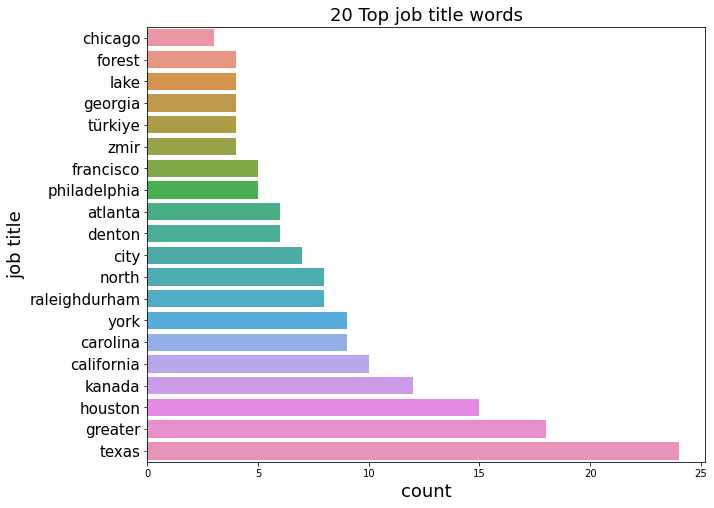

In [49]:
# dict(genres_counts) convert to dictionary
dfg = df_location.tail(20)
plt.figure(figsize = (10,8))
sns.barplot(data = dfg, y= dfg.index, x='count_location')
plt.title('20 Top job title words', fontsize =18)
plt.xlabel('count', fontsize =18)
plt.ylabel('job title', fontsize =18)
plt.yticks(fontsize=15)
plt.show()

In [50]:
for x in count_location:
  if x == 'area':
    count_location.remove(x)

In [51]:
all_words_joined2 = ' '.join(count_location)
all_words_joined2

'houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater york city kanada francisco kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas houston texas kanada raleighdurham north carolina denton texas houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater york city kanada francisco houston texas chicago illinois houston texas chicago illinois houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater york city kanada francisco kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater york city kanada francisco kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas raleighdurham north carolina denton texas greater york city francisco greater philadelphia lake forest california houston texas atlanta georgia austin texas ja

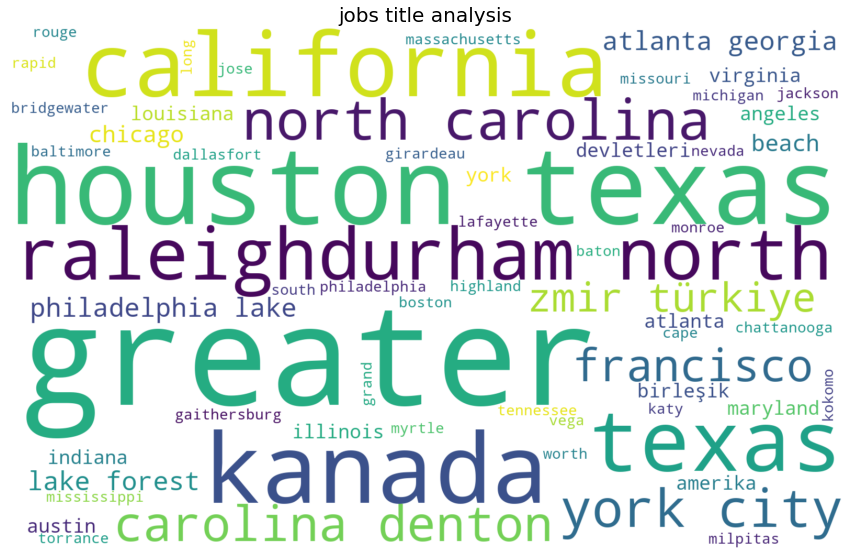

In [52]:
# plot the WordCloud image
generate_show_wordcloud(all_words_joined2)

# TF-IDF

In [53]:
def join_clean_text_lem(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [t for t in tokens if t.isalpha()] # remove numeric 
    tokens = [word for word in tokens if not any(c.isdigit() for c in word)]                      
    text = [wn.lemmatize(word) for word in tokens if word not in stopword] # stemming and remove stopword 
    # remove empty tokens and tokens of 1 letter 
    text = [t for t in text if len(t) > 3]
    # join all
    text = " ".join(text)
    return text

In [54]:
df['join_job_clean_lem'] = df['job_title'].apply(lambda row: join_clean_text_lem(row))
df['join_location_clean_lem'] = df['location'].apply(lambda row: join_clean_text_lem(row))

In [55]:
df['join_job_clean_lem'].head()

0    bauer college business graduate magna laude as...
1    native english teacher epik english program korea
2                 aspiring human resource professional
3                  people development coordinator ryan
4         advisory board member celal bayar university
Name: join_job_clean_lem, dtype: object

In [56]:
# Prep our Text for Modelling
vectorizer_job = TfidfVectorizer(stop_words='english', ngram_range = (1, 2))
job_tfidf = vectorizer_job.fit_transform(df['join_job_clean_lem'])
job_tfidf.shape

(104, 335)

In [57]:
job_tfidf

<104x335 sparse matrix of type '<class 'numpy.float64'>'
	with 1089 stored elements in Compressed Sparse Row format>

In [58]:
#f = pd.DataFrame(tfidf_matrix.toarray(), columns= tfidf_vectorizer.get_feature_names())
vec_job_df = pd.DataFrame(job_tfidf.toarray(), columns= vectorizer_job.get_feature_names())
vec_job_df.tail()

,administration,administration excellence,administrative,administrative professional,admission,admission representative,advisory,advisory board,america,america groupe,analyst,analytics,analytics traveler,army,army national,aspiring,aspiring human,assistant,assistant styczynski,atlanta,bachelor,bachelor science,bauer,bauer college,bayar,bayar university,beach,beneteau,biology,biology victoria,board,board member,brand,brand portfolio,buckhead,buckhead atlanta,business,business graduate,business intelligence,business management,business partner,care,celal,celal bayar,center,center long,chapman,chapman university,chro,chro marketing,college,college aspiring,college business,communication,communication officer,community,community medical,compensation,conflict,conflict management,coordinator,coordinator intercontinental,coordinator ryan,create,create inclusive,customer,customer service,data,data organization,delphi,delphi hardware,development,development coordinator,director,director administration,director human,employment,employment opportunity,endemol,endemol shine,energetic,energetic teamfocused,energy,energy gphr,engaging,engaging work,engie,engie houston,engineer,engineer information,english,english program,english teacher,entrylevel,entrylevel human,environment,environmental,epik,epik english,excellence,excellence logging,executive,executive japan,experienced,experienced retail,generalist,generalist loparex,generalist position,generalist schwans,generalist scottmadden,gphr,gphr sphr,graduate,graduate magna,graduating,graduating seeking,groupe,groupe beneteau,guard,guard recruiter,hardware,hardware paint,heil,heil environmental,helping,helping create,houston,houston woodland,hris,hris generalist,human,human resource,humber,humber college,illinois,illinois university,inclusive,inclusive engaging,indiana,indiana university,information,information specialist,intelligence,intelligence analytics,intercontinental,intercontinental buckhead,international,internship,internship human,japan,japan tobacco,junior,junior engineer,kokomo,kokomo business,korea,laude,laude aspiring,lead,lead official,leader,leader software,liberal,liberal major,logging,long,long beach,loparex,louis,love,love data,luxottica,magna,magna laude,major,major aspiring,management,management major,management policy,management retail,management student,managementbenefits,managementbenefits compensation,manager,manager aspiring,manager delphi,manager endemol,manager graduating,manager seeking,marketing,marketing communication,medical,medical center,member,member celal,national,national guard,native,native english,north,north america,nortia,nortia staffing,office,office manager,officer,officer engie,official,official western,open,open travel,opportunity,opportunity customer,opportunity open,organization,paint,partner,partner heil,passionate,passionate helping,patient,patient care,payroll,payroll administrative,people,people development,policy,policy procedurestalent,portfolio,portfolio executive,position,position human,position louis,procedurestalent,procedurestalent managementbenefits,professional,professional energetic,professional passionate,professional world,program,program korea,programmer,programmer love,recruiter,recruiter office,recruiting,recruiting professional,relocation,representative,representative community,research,research assistant,resource,resource analyst,resource business,resource conflict,resource coordinator,resource generalist,resource hris,resource management,resource manager,resource north,resource opportunity,resource payroll,resource position,resource professional,resource specialist,resource staffing,retail,retail manager,retired,retired army,ryan,schwans,science,science biology,scottmadden,seeking,seeking employment,seeking entrylevel,seeking human,seeking internship,seeking position,senior,senior human,senior specialist,service,service patient,shine,shine north,software,specialist,specialist luxottica,specialist programmer,sphr,staffing,staf

In [59]:
def get_tf_idf_query_similarity(cleaning_text, tfidf_doc, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    # Prep our Text for Modelling
    vectorizer_text = TfidfVectorizer(stop_words='english', ngram_range = (1, 2))
    job_tfidf = vectorizer_text.fit_transform(cleaning_text)

    query_tfidf = vectorizer_text.transform([query])
    cos_sim = cosine_similarity(query_tfidf, tfidf_doc).flatten()
    
    return cos_sim

In [60]:
job_title = 'aspiring human ressources'
fit_cos_sim = get_tf_idf_query_similarity(df['join_job_clean_lem'], job_tfidf, job_title)
df['fit'] = fit_cos_sim

In [61]:
df[['fit', 'connection']].sort_values(by= 'fit', ascending = False).head(20)

,fit,connection
45,0.611085,44
16,0.611085,44
2,0.611085,44
57,0.611085,44
32,0.611085,44
20,0.611085,44
96,0.611085,71
59,0.529739,1
35,0.529739,1
48,0.529739,1


In [62]:
df[['fit', 'connection']].corr()

,fit,connection
fit,1.000000,-0.547445
connection,-0.547445,1.000000


In [63]:
df[['fit', 'connection',  'location_clean_lem']].sort_values(by= 'fit', ascending = False).head(20)

,fit,connection,location_clean_lem
45,0.611085,44,"[raleighdurham, north, carolina, area]"
16,0.611085,44,"[raleighdurham, north, carolina, area]"
2,0.611085,44,"[raleighdurham, north, carolina, area]"
57,0.611085,44,"[raleighdurham, north, carolina, area]"
32,0.611085,44,"[raleighdurham, north, carolina, area]"
20,0.611085,44,"[raleighdurham, north, carolina, area]"
96,0.611085,71,"[kokomo, indiana, area]"
59,0.529739,1,"[greater, york, city, area]"
35,0.529739,1,"[greater, york, city, area]"
48,0.529739,1,"[greater, york, city, area]"


# GloVe (Global Vectors)

In GloVe, we measure the similarity of the hidden factors between words to predict their co-occurrence count.

GloVe embeddings have been used in more than 2100 papers, and counting! You can use these pre-trained embeddings whenever you need a way to quantify word co-occurrence (which also captures some aspects of word meaning.)

In [64]:
# scipy
from scipy.spatial.distance import cosine
# gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

In [65]:
# load glove.6B.50d.txt and save in the directory
#https://nlp.stanford.edu/projects/glove/

In [66]:
# Create temp file and save converted embedding into it
target_file = get_tmpfile('word2vec.6B.50d.txt')
glove2word2vec('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/glove.6B.50d.txt', target_file) 

# Load the converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('word2vec.6B.50d.bin.gz', binary=True)

(400000, 50)

In [67]:
# Define a function to vectorize a sentence's words
def doc_token_vectors(sentence, model, sentence_vector_list, vector_dimensions):
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
    
    for j in range(0, len(word_tokens)):
        if word_tokens[j] in filtered_words:
            token_vector = model[word_tokens[j]]
        else:
            token_vector = np.zeros(vector_dimensions)
        sentence_vector_list.append(token_vector)
    
    return sentence_vector_list

In [68]:
# Vectorize job title using GloVe model
glove_vectors = []
for i in range(0, len(df)):
    glove_sentence_vector = []
    doc_token_vectors(df['join_job_clean_lem'][i], glove_model, glove_sentence_vector, 50)
    glove_vectors.append(glove_sentence_vector)

AttributeError: ignored

In [ ]:
lemmatized_phrase = 'Aspiring human resources'
# Vectorize searched phrase using GloVe model
glove_search_phrase_vector = []
doc_token_vectors(lemmatized_phrase, glove_model, glove_search_phrase_vector, 50)